In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 1us/step


In [ ]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def resize_load_img(path_to_img, target_shape):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, target_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

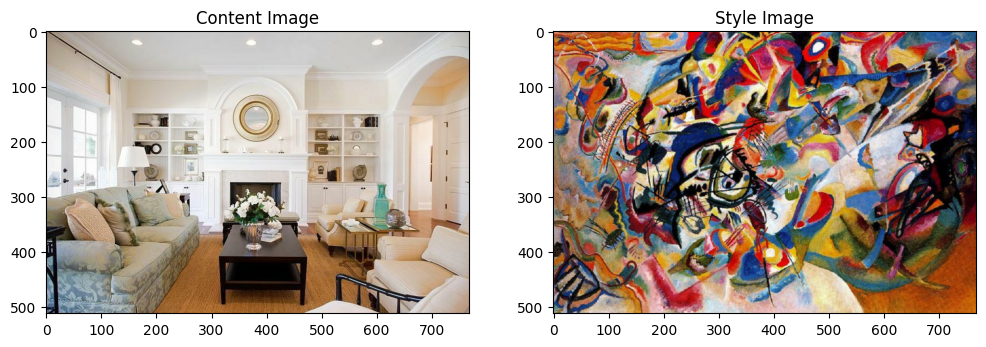

In [ ]:
original_image_path = 'ADE_val_00001519.jpg'
original_image = load_img(original_image_path)
content_image = resize_load_img(original_image_path, (original_image.shape[0], original_image.shape[1]))

style_image = resize_load_img(style_path, (original_image.shape[0], original_image.shape[1]))

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

assert content_image.shape == style_image.shape

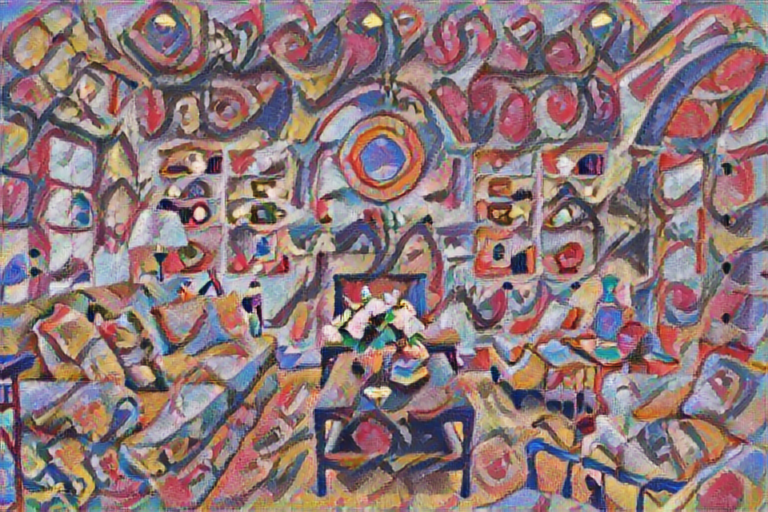

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
# Example of accessing a specific function if you know the signature key
if 'serving_default' in hub_model.signatures:
    serving_default = hub_model.signatures['serving_default']
    print("Input Specs:", serving_default.inputs)
    print("Output Specs:", serving_default.outputs)


Input Specs: [<tf.Tensor 'placeholder:0' shape=(None, None, None, 3) dtype=float32>, <tf.Tensor 'placeholder_1:0' shape=(None, None, None, 3) dtype=float32>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_1a_3x3_weights:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_1a_3x3_batchnorm_beta:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_1a_3x3_batchnorm_moving_mean:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_1a_3x3_batchnorm_moving_variance:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_2a_3x3_weights:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_2a_3x3_batchnorm_beta:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_inceptionv3_conv2d_2a_3x3_batchnorm_moving_mean:0' shape=<unknown> dtype=resource>, <tf.Tensor 'statefulpartitionedcall_ince

In [ ]:
import tensorflow as tf

# Load the model
tf.saved_model.load(hub_model)

TypeError: Expected binary or unicode string, got <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7dfebf0cbe20>

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import visualkeras

visualkeras.layered_view(segmentation_module).show() # display using your system viewer

AttributeError: 'SegmentationModule' object has no attribute 'layers'

In [ ]:
def get_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.array(pred_color)
    # display(PIL.Image.fromarray(im_vis))
    plt.figure(figsize=(10, 10))
    plt.imshow(im_vis)
    plt.axis('off')
    plt.show()
    return im_vis

sofa:


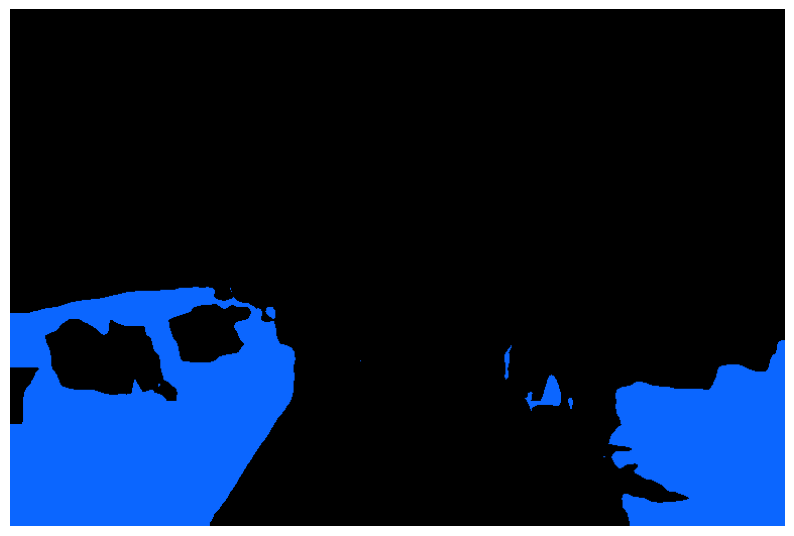

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)

# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()


sofa = get_result(img_original, pred, 23)
sofa_location = []
for x in range(sofa.shape[0]):
    for y in range(sofa.shape[1]):
        if (sofa[x][y] !=[0, 0, 0]).any():
            sofa_location.append((x, y))

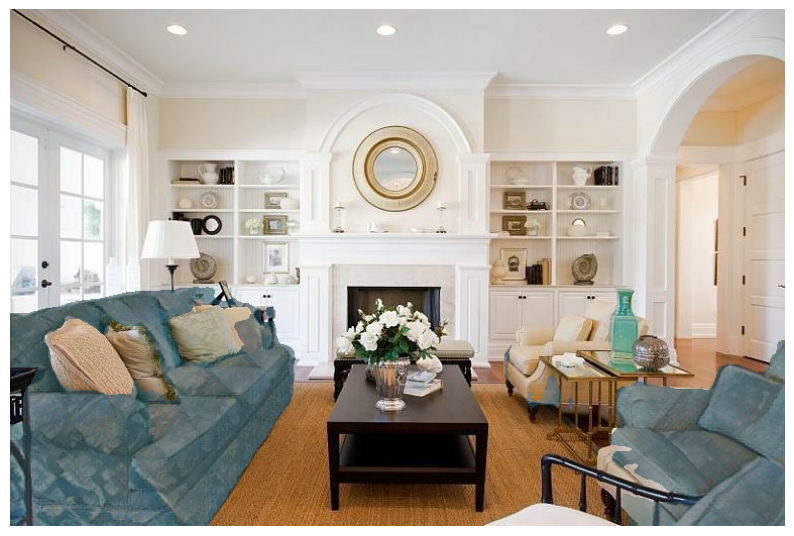

In [ ]:
import matplotlib.pyplot as plt

newImage = content_image.numpy()[0].copy()
for (x, y) in sofa_location:
  newImage[x][y] = stylized_image.numpy()[0][x][y]

plt.figure(figsize=(10, 10))
plt.imshow(newImage)
plt.axis('off')
plt.show()

In [ ]:
names

{1: 'wall',
 2: 'building',
 3: 'sky',
 4: 'floor',
 5: 'tree',
 6: 'ceiling',
 7: 'road',
 8: 'bed',
 9: 'windowpane',
 10: 'grass',
 11: 'cabinet',
 12: 'sidewalk',
 13: 'person',
 14: 'earth',
 15: 'door',
 16: 'table',
 17: 'mountain',
 18: 'plant',
 19: 'curtain',
 20: 'chair',
 21: 'car',
 22: 'water',
 23: 'painting',
 24: 'sofa',
 25: 'shelf',
 26: 'house',
 27: 'sea',
 28: 'mirror',
 29: 'rug',
 30: 'field',
 31: 'armchair',
 32: 'seat',
 33: 'fence',
 34: 'desk',
 35: 'rock',
 36: 'wardrobe',
 37: 'lamp',
 38: 'bathtub',
 39: 'railing',
 40: 'cushion',
 41: 'base',
 42: 'box',
 43: 'column',
 44: 'signboard',
 45: 'chest',
 46: 'counter',
 47: 'sand',
 48: 'sink',
 49: 'skyscraper',
 50: 'fireplace',
 51: 'refrigerator',
 52: 'grandstand',
 53: 'path',
 54: 'stairs',
 55: 'runway',
 56: 'case',
 57: 'pool',
 58: 'pillow',
 59: 'screen',
 60: 'stairway',
 61: 'river',
 62: 'bridge',
 63: 'bookcase',
 64: 'blind',
 65: 'coffee',
 66: 'toilet',
 67: 'flower',
 68: 'book',
 69: '

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
os.chdir("/content/drive/My Drive/Datasets")
!kaggle competitions download -c imaterialist-fashion-2019-FGVC6

100% 19.1G/19.1G [17:10<00:00, 22.8MB/s]
100% 19.1G/19.1G [17:10<00:00, 19.9MB/s]


In [ ]:
!unzip imaterialist-fashion-2019-FGVC6.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/e40ee400321e10b4bc5d62af651842e1.jpg  
  inflating: train/e410de5d233c91312ff90a45a879cb20.jpg  
  inflating: train/e413414d90a71c9b27042564d09bed3d.jpg  
  inflating: train/e414506b27e50edd15976daaddd11b23.jpg  
  inflating: train/e4158743cd44983044b8209eadcd9b11.jpg  
  inflating: train/e415895977e5058a184ac29b84a82c17.jpg  
  inflating: train/e4159898123f63bdcf1c30b368dba08d.jpg  
  inflating: train/e4162ff093f6af5d8f15e5c80c0efbf2.jpg  
  inflating: train/e4171b74a659be0e809fcc5d658039ec.jpg  
  inflating: train/e417811025bc0a376d2d9b37f20e540c.jpg  
  inflating: train/e419b84432972cc0bd053c97027b7c0c.jpg  
  inflating: train/e41a808744c8e4b5fa373ca8948cbf78.jpg  
  inflating: train/e41c28967b194dd829e678aa67c5b3a0.jpg  
  inflating: train/e41ca3fd0aaf5320ae4327e66492621d.jpg  
  inflating: train/e41ecedd475a4830cd45e3e574bd8ba0.jpg  
  inflating: train/e421c9b15f9a64e48a1c198e0752e668.jpg  
  inflating: train/e4

In [ ]:
os.chdir("/content/")

In [ ]:
!chmod +x download_ADE20K.sh
!./download_ADE20K.sh

Streaming output truncated to the last 5000 lines.
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00010086.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00002526.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00002954.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00007278.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00012415.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00012867.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00000612.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00016979.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00013255.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_00013980.png  
  inflating: ./data/ADEChallengeData2016/annotations/training/ADE_train_0000105

In [ ]:
!python3 train.py --gpus 0 --cfg config/ade20k-resnet101dilated-ppm_deepsup.yaml

/content/train.py:209: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert LooseVersion(torch.__version__) >= LooseVersion('0.4.0'), \
[2024-04-06 21:35:19,370 INFO train.py line 240 43242] Loaded configuration file config/ade20k-resnet101dilated-ppm_deepsup.yaml
[2024-04-06 21:35:19,370 INFO train.py line 241 43242] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet101dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet101dilated
  fc_dim: 2048
  weights_decoder: 
  weights_encoder: 
TEST:
  batch_size: 1
  checkpoint: epoch_25.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 

In [ ]:
import torch
print(torch.cuda.device_count())
print(torch.__version__)
print(torch.version.cuda)


1
2.2.1+cu121
12.1


In [ ]:
"./drive/My Drive/Datasets/train"
"./drive/My Drive/Datasets/test"

DATASET:
  root_dataset: "./data/"
  list_train: "./data/training.odgt"
  list_val: "./data/validation.odgt"
  num_class: 150
  imgSizes: (300, 375, 450, 525, 600)
  imgMaxSize: 1000
  padding_constant: 32
  segm_downsampling_rate: 4
  random_flip: True

MODEL:
  arch_encoder: "hrnetv2"
  arch_decoder: "c1"
  fc_dim: 720

TRAIN:
  batch_size_per_gpu: 2
  num_epoch: 30
  start_epoch: 0
  epoch_iters: 5000
  optim: "SGD"
  lr_encoder: 0.02
  lr_decoder: 0.02
  lr_pow: 0.9
  beta1: 0.9
  weight_decay: 1e-4
  deep_sup_scale: 0.4
  fix_bn: False
  workers: 16
  disp_iter: 20
  seed: 304

VAL:
  visualize: False
  checkpoint: "epoch_30.pth"

TEST:
  checkpoint: "epoch_30.pth"
  result: "./"

DIR: "ckpt/ade20k-hrnetv2-c1"


In [ ]:
training_entries

['{"fpath_img": "ADEChallengeData2016/images/training/ADE_train_00000001.jpg", "fpath_segm": "ADEChallengeData2016/annotations/training/ADE_train_00000001.png", "width": 683, "height": 512}\n',
 '{"fpath_img": "ADEChallengeData2016/images/training/ADE_train_00000002.jpg", "fpath_segm": "ADEChallengeData2016/annotations/training/ADE_train_00000002.png", "width": 711, "height": 512}\n']

In [ ]:
import tensorflow as tf
import json
import numpy as np

def load_and_preprocess_image(path_to_image, path_to_seg_map, img_size=(256, 256)):
    # Load and preprocess the image
    image = tf.io.read_file(path_to_image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize to [0, 1]

    # Load and preprocess the segmentation map
    seg_map = tf.io.read_file(path_to_seg_map)
    seg_map = tf.image.decode_png(seg_map, channels=1)
    seg_map = tf.image.resize(seg_map, img_size, method='nearest')
    seg_map = tf.cast(seg_map, tf.int32)  # Assuming your seg map is already categorical

    return image, seg_map


In [ ]:
training_entries

['{"fpath_img": "ADEChallengeData2016/images/training/ADE_train_00000001.jpg", "fpath_segm": "ADEChallengeData2016/annotations/training/ADE_train_00000001.png", "width": 683, "height": 512}\n',
 '{"fpath_img": "ADEChallengeData2016/images/training/ADE_train_00000002.jpg", "fpath_segm": "ADEChallengeData2016/annotations/training/ADE_train_00000002.png", "width": 711, "height": 512}\n']

In [ ]:
def create_dataset(file_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

import scipy.io
import pandas as pd

# Load the color mappings for semantic segmentation
color_mat = scipy.io.loadmat('./data/color150.mat')

# Load the class information
class_info_df = pd.read_csv('./data/object150_info.csv')

# Load a couple of entries from the training and validation datasets to examine their structure
with open('./data/training.odgt') as f:
    training_entries = [f.readline() for _ in range(2)]

with open('./data/validation.odgt') as f:
    validation_entries = [f.readline() for _ in range(2)]

# Prepare file_paths array containing tuples of (image_path, segmentation_map_path)
file_paths = [(json.loads(entry)['fpath_img'], json.loads(entry)['fpath_segm']) for entry in training_entries]

# Create your dataset
dataset = create_dataset(file_paths, batch_size=4)


TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__load_and_preprocess_image() missing 1 required positional argument: 'path_to_seg_map'
